In [1]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 

# list each folder of folder "games"
# get all folders
folders = glob.glob("games_yosha/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value
    
    
   

    # number of moves
    game_length = len(list(game.mainline_moves()))




    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]


    # get the Elo of the engine (if any)

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dfframe

    df = df.append({"white": white, "black": black, "white_elo": white_elo, "black_elo": black_elo, "result": result, "nmoves" : game_length, "nstarting_move": nmove_value, "pgn_base" : pgn_base, "temperature" : temperature, "random_engine" : random_engine, "has_illegal" : has_illegal, "illegal_move" : illegal_move, "folder_name" : folder}, ignore_index=True)


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...



In [2]:
df

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name
0,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,141,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameac41f898-b3ca-4b96-90fb-19246e...
1,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,58,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamecc87b77a-986f-4846-9830-095662...
2,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,53,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameb0a3fbe2-63a6-4fd4-8a69-605854...
3,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,75,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc31f43d-e0e8-4301-b73f-aed98e...
4,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,91,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gameac4eefd4-b0a5-4289-84e9-7b2f93...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,115,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc232246-8d2e-42b4-bef2-0cc18a...
77,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,88,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea8b0b6a6-ad94-45bd-8170-522304...
78,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,134,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game8fdf34d5-b73e-4812-8789-d11428...
79,Stockfish,gpt-3.5-turbo-instruct,1954,?,1/2-1/2,161,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea541823d-a8bb-45fa-af00-adfafc...


In [3]:
import re

# Open and read the content of metainformation.txt
with open("games/gamea7e73056-951a-417d-b671-0a60fba939f7/" + 'metainformation.txt', 'r') as file:
    content = file.read()

# Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
match = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)

if match:
    # Extract and clean up the matched content
    extracted_content = match.group(1).strip()
    print(extracted_content)
else:
    print('No match found')

0


In [4]:
print(len(df), "games compiled in the database")

81 games compiled in the database


In [5]:
import chess
import chess.pgn
import io 


# for column "pgn_base", I'd like to transform the string into a list of moves

def pgn_to_list(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    g.mainline_moves()
    return str(g.mainline_moves())

def is_base_prompt(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    # [Event "FIDE World Championship Match 2024"]\n[Site "Los Angeles, USA"]
    return g.headers["Event"] == "FIDE World Championship Match 2024" and g.headers["Site"] == "Los Angeles, USA"

def has_illegal_moves(pgn):
    # exist g.headers["UnknownSAN"] 
    g = chess.pgn.read_game(io.StringIO(pgn))
    # key in array
    return "UnknownSAN" in g.headers

df["pgn_base_moves"] = df["pgn_base"].apply(pgn_to_list) # extract only moves
df["base_pgn_prompt"] = df["pgn_base"].apply(is_base_prompt) # extract only prompt
# df.sort_values(by=['nstarting_move'])
df['temperature'] = pd.to_numeric(df['temperature'])

In [6]:
# Frequencies based on piece colors
players = ['gpt-3.5-turbo-instruct', 'gpt-4', 'gpt-3.5-turbo', 'text-davinci-003']
color_breakdown = {}
for player in players:
    white_count = df[df['white'] == player].shape[0]
    black_count = df[df['black'] == player].shape[0]
    color_breakdown[player] = {'white': white_count, 'black': black_count}

for player in players:
    nwhite = color_breakdown[player]['white']
    nblack = color_breakdown[player]['black']
    print(" *", player, ":", nwhite+nblack, "games, among", nwhite, "with white piece and", nblack, "with black pieces")


 * gpt-3.5-turbo-instruct : 81 games, among 0 with white piece and 81 with black pieces
 * gpt-4 : 0 games, among 0 with white piece and 0 with black pieces
 * gpt-3.5-turbo : 0 games, among 0 with white piece and 0 with black pieces
 * text-davinci-003 : 0 games, among 0 with white piece and 0 with black pieces


In [7]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,141,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameac41f898-b3ca-4b96-90fb-19246e...,,False
1,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,58,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamecc87b77a-986f-4846-9830-095662...,,False
2,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,53,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameb0a3fbe2-63a6-4fd4-8a69-605854...,,False
3,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,75,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc31f43d-e0e8-4301-b73f-aed98e...,,False
4,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,91,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gameac4eefd4-b0a5-4289-84e9-7b2f93...,,False


In [8]:
df.to_csv("games_db_yosha.csv")

In [9]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        if total_wins + total_losses + total_draws == 0:
            return 0.0
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


text-davinci-003 (completion)

In [10]:
df_davinci = df.query("white == 'text-davinci-003' or black == 'text-davinci-003'")
print(len(df_davinci), "games with davinci")
print("with white pieces", len(df.query("white == 'text-davinci-003'")))
print("with black pieces", len(df.query("black == 'text-davinci-003'")))

print(len(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'")), "games against random chess engine")
# print(compute_score(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'"), "text-davinci-003"))


print(len(df_davinci.query("has_illegal == True")), "games with illegal move")
print("score", compute_score(df_davinci, "text-davinci-003"))

print("the only game with no illegal move is")
df_davinci.query("has_illegal == False")


# box plot of df_davinci['nmoves']
print("The longest game was", df_davinci['nmoves'].max()/2, "moves")
print("The shortest game was", df_davinci['nmoves'].min()/2, "moves")
print("The average game length was", df_davinci['nmoves'].mean()/2, "moves")
print("The median game length was", df_davinci['nmoves'].median()/2, "moves")



0 games with davinci
with white pieces 0
with black pieces 0
0 games against random chess engine
0 games with illegal move
score 0.0
the only game with no illegal move is
The longest game was nan moves
The shortest game was nan moves
The average game length was nan moves
The median game length was nan moves


In [11]:
df.sort_values(by=['pgn_base'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,141,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameac41f898-b3ca-4b96-90fb-19246e...,,False
57,Stockfish,gpt-3.5-turbo-instruct,1871,?,0-1,66,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game759073af-1266-4266-8072-797742...,,False
56,Stockfish,gpt-3.5-turbo-instruct,1871,?,1-0,133,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamef302ae5e-faaf-4ef3-a3b2-36e22f...,,False
55,Stockfish,gpt-3.5-turbo-instruct,1871,?,0-1,172,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game39187607-e0f5-4521-928e-e46938...,,False
54,Stockfish,gpt-3.5-turbo-instruct,1871,?,0-1,78,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game6592812f-c8c1-4eca-a9aa-2e46f3...,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,Stockfish,gpt-3.5-turbo-instruct,1694,?,0-1,80,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game76feac0f-8e55-49a5-8570-3b92e4...,,False
22,Stockfish,gpt-3.5-turbo-instruct,1694,?,1-0,83,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamec6fe0ff8-f7d1-4d14-8861-5d9bfe...,,False
21,Stockfish,gpt-3.5-turbo-instruct,1694,?,1-0,49,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game59b1fb0d-b0e7-40e7-9315-bc2bd0...,,False
39,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,144,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game50deb62b-ade0-40e7-b906-235e00...,,False


In [12]:
df.sort_values(by=['white_elo'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
14,Stockfish,gpt-3.5-turbo-instruct,1694,?,1/2-1/2,138,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea4187bf2-f3e0-44b2-ab5c-91aedf...,,False
27,Stockfish,gpt-3.5-turbo-instruct,1694,?,1-0,69,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc7dd30a-5d00-45a9-830c-5e485d...,,False
26,Stockfish,gpt-3.5-turbo-instruct,1694,?,*,85,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamec797972f-2990-4611-a312-4433dd...,,False
25,Stockfish,gpt-3.5-turbo-instruct,1694,?,0-1,100,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game22edbe69-afb6-417b-98a2-5035be...,,False
24,Stockfish,gpt-3.5-turbo-instruct,1694,?,1-0,77,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamef268c8e6-a4ec-419a-a131-87e118...,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,221,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamec5b08257-48d7-48f3-8f2a-29d5a6...,,False
61,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,78,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamec10b7b05-1362-41b6-a170-3191df...,,False
79,Stockfish,gpt-3.5-turbo-instruct,1954,?,1/2-1/2,161,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea541823d-a8bb-45fa-af00-adfafc...,,False
69,Stockfish,gpt-3.5-turbo-instruct,1954,?,1/2-1/2,147,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game7cfbec2c-0e4d-4bf9-8a1f-d85c78...,,False


In [13]:
df_non_random = df.query("random_engine == False and nstarting_move <= 2")

def analyze_model_performance(df_m, model_gpt_name):    

    print(f"Analysis against SF (no random engine, no random first moves) for model: {model_gpt_name}")

    model_games = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == False")
    score_model = compute_score(model_games, model_name=model_gpt_name)
    print("Score", round(100*score_model, 2), "% for games with only legal moves")
    score, t = compute_score(model_games, model_name=model_gpt_name, percentage=False)
    print("Score", score, "for games with only legal moves (", t, "games)")

    tot = len(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')"))
    print("Score", round(100*(score/tot), 2), "% for all games, being legal or illegal")
    print("Score", score, "for all games (", tot, "games)")

    vals_model = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")['has_illegal'].value_counts()
    ntot = vals_model.get(0, 0) + vals_model.get(1, 0)

    print("Out of", ntot ,"games against SF,", vals_model.get(0, 0), "were legal games and", vals_model.get(1, 0), "were illegal games, hence", round((vals_model.get(1, 0)/ntot)*100), "% of illegal games.")
    print(vals_model.get(0, 0), "legal games and", vals_model.get(1, 0), "illegal games", "(out of", ntot, "total games)")
    print(round((vals_model.get(1, 0)/ntot)*100), "% of illegal games")

    print("Illegal moves are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True")['illegal_move'].value_counts().to_markdown())

    print("Illegal moves with n first random move are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and nstarting_move > 2")['illegal_move'].value_counts().to_markdown())

# Example usage:
analyze_model_performance(df_non_random, 'gpt-3.5-turbo-instruct')
# analyze_model_performance(df_non_random, 'gpt-4')

# analyze_model_performance(df_random, 'gpt-4')

# analyze_model_performance(df_random, 'gpt-3.5-turbo')



Analysis against SF (no random engine, no random first moves) for model: gpt-3.5-turbo-instruct
Score 40.97 % for games with only legal moves
Score 29.5 for games with only legal moves ( 72 games)
Score 36.42 % for all games, being legal or illegal
Score 29.5 for all games ( 81 games)
Out of 81 games against SF, 72 were legal games and 9 were illegal games, hence 11 % of illegal games.
72 legal games and 9 illegal games (out of 81 total games)
11 % of illegal games
Illegal moves are:
|     |   illegal_move |
|:----|---------------:|
| 0-1 |              9 |
Illegal moves with n first random move are:
| illegal_move   |
|----------------|


In [14]:
len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')"))

81

In [15]:
def count_moves_and_illegals(df_l, gpt_model_name):
    illegal_white_moves = len(df_l.query(f"(white == '{gpt_model_name}') and has_illegal == True"))
    total_white_moves = len(df_l.query(f"(white == '{gpt_model_name}')"))
    total_black_moves = len(df_l.query(f"(black == '{gpt_model_name}')"))
    illegal_black_moves = len(df_l.query(f"(black == '{gpt_model_name}') and has_illegal == True"))

    print(illegal_white_moves, "illegal moves with white")
    print(total_white_moves)
    print(total_black_moves)
    print(illegal_black_moves, "illegal moves with black")

    return illegal_white_moves, total_white_moves, total_black_moves, illegal_black_moves

count_moves_and_illegals(df_non_random, 'gpt-3.5-turbo-instruct')



0 illegal moves with white
0
81
9 illegal moves with black


(0, 0, 81, 9)

In [16]:
mask = (df_non_random["white"] == 'gpt-3.5-turbo-instruct') | (df_non_random["black"] == 'gpt-3.5-turbo-instruct')
illegal_gpt35vsSF_instruct = df_non_random.loc[mask & (df_non_random["has_illegal"] == True)].copy()
illegal_gpt35vsSF_instruct["temperature"] = illegal_gpt35vsSF_instruct["temperature"].astype(float)

print(illegal_gpt35vsSF_instruct[["temperature"]].value_counts())

t8 = len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `temperature` == '0.8'")) / len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')"))
print(round(100*t8, 2), "% of games with temperature 0.8")

print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `temperature` == '0.8' and has_illegal == True")['illegal_move'].value_counts().to_markdown())


temperature
0.0            9
dtype: int64
0.0 % of games with temperature 0.8
| illegal_move   |
|----------------|


In [17]:
illegal_gpt35vsSF_instruct = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and has_illegal == True") # [['pgn_base']].value_counts()
n = 0
m = 0
for i, row in illegal_gpt35vsSF_instruct.iterrows():
    if "Rennes FRA" in row["pgn_base"]:
        n = n + 1
    else:
        m = m + 1

print(len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and pgn_base.str.contains('Rennes FRA')")), "games with altered prompt")
print(len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and pgn_base.str.contains('Rennes FRA')")) / len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")) * 100, "% games with altered prompt")

print(n, "illegal games with altered prompts and", m, "illegal games with original prompts")
print(illegal_gpt35vsSF_instruct.query("pgn_base.str.contains('Rennes FRA')")['illegal_move'].value_counts())

print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and has_illegal == True")['nstarting_move'].value_counts().to_markdown())


0 games with altered prompt
0.0 % games with altered prompt
0 illegal games with altered prompts and 9 illegal games with original prompts
Series([], Name: illegal_move, dtype: int64)
|    |   nstarting_move |
|---:|-----------------:|
|  1 |                9 |


In [18]:
print("Does random first moves impact?")
print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")['nstarting_move'].value_counts().to_markdown())

Does random first moves impact?
|    |   nstarting_move |
|---:|-----------------:|
|  1 |               81 |


In [19]:
def count_invalid_games(df_l, model_gpt_name):
    query_str = f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and illegal_move != '1-0' and illegal_move != '1-'"
    
    x = 0
    for _, r in df_l.query(query_str).iterrows():
        if '=' in r['illegal_move'] or '{' in r['illegal_move']:
            continue

        print(r['illegal_move'], r['folder_name'])
        x += 1 

    percentage = round(x / len(df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")), 3) * 100
    print(f'If we consider "1-0", "comments", and "unspecified promotions" as fixable, then {percentage} % are non valid games')

    return percentage

count_invalid_games(df_non_random, 'gpt-3.5-turbo-instruct')


    

0-1 games_yosha/gameac4eefd4-b0a5-4289-84e9-7b2f93223f54
0-1 games_yosha/game31767cf0-7145-4798-af1a-cbc99d65ace8
0-1 games_yosha/gamec797972f-2990-4611-a312-4433ddd56fb5
0-1 games_yosha/gamee099abf1-e680-4aa1-a429-3247c1b772cf
0-1 games_yosha/game45307c19-414f-4671-a6be-9f4e624af391
0-1 games_yosha/gamebf09a82a-7b2d-4816-b125-afb87b6eaeb1
0-1 games_yosha/gamefa4d9bcd-9932-49bf-8880-c439fd7ea1fd
0-1 games_yosha/gamea0d12b34-eb64-44b5-83e9-26ae152fbd6e
0-1 games_yosha/game6372e7a4-c214-4386-85e5-2ee5f38d32c9
If we consider "1-0", "comments", and "unspecified promotions" as fixable, then 11.1 % are non valid games


11.1

In [20]:
print("Qualitative analysis of illegal moves:")

import pandas as pd
from stockfish import Stockfish

# A list to store your data
data_list = []

illegal_moves10 = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and illegal_move == '1-0'")

for index, row in illegal_moves10.iterrows():
    if row['white'] == 'gpt-3.5-turbo-instruct':
        color = "White"
    else:
        color = "Black"

    # read the PGN file
    with open(row['folder_name'] + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)

        stockfish = Stockfish("./stockfish/stockfish/stockfish-ubuntu-x86-64-avx2")
        stockfish.set_position([str(m) for m in game.mainline_moves()])
        # stockfish._go_time(5000)
        ev = stockfish.get_evaluation()

        # Create an evaluation string
        if ev['type'] == 'cp':
            evaluation = str(ev['value']/100)
        else:
            evaluation = "Mate in " + str(ev['value'])

        # Append the dictionary to your list
        data_list.append({
            "GPT Color": color,
            "Assessment": evaluation
        })

# Convert the list of dictionaries into a dataframe
df_results = pd.DataFrame(data_list)

# If you want to see the first few rows of your dataframe:
print(df_results.to_markdown())


Qualitative analysis of illegal moves:



In [21]:
df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct' and has_illegal == True)").sort_values(by="nmoves", ascending=False)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
10,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,139,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/game31767cf0-7145-4798-af1a-cbc99d...,,False
72,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,113,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamea0d12b34-eb64-44b5-83e9-26ae15...,,False
43,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,111,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/game45307c19-414f-4671-a6be-9f4e62...,,False
46,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,109,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamefa4d9bcd-9932-49bf-8880-c439fd...,,False
30,Stockfish,gpt-3.5-turbo-instruct,1694,?,*,99,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamee099abf1-e680-4aa1-a429-3247c1...,,False
4,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,91,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gameac4eefd4-b0a5-4289-84e9-7b2f93...,,False
26,Stockfish,gpt-3.5-turbo-instruct,1694,?,*,85,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamec797972f-2990-4611-a312-4433dd...,,False
44,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,85,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gamebf09a82a-7b2d-4816-b125-afb87b...,,False
75,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,65,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/game6372e7a4-c214-4386-85e5-2ee5f3...,,False


In [22]:
j = 0
cp_g = 0
for index, row in df_results.iterrows():
    if 'Mate' in row['Assessment']:
        j = j + 1
    elif float(row['Assessment']) > 5.0:
        cp_g = cp_g + 1

print(j, "games with mate", "out of", len(df_results), "games")
print(cp_g, "games with cp > 5.0", "out of", len(df_results), "games")
print(len(df_results) - (j+cp_g), "games with cp < 5.0", "out of", len(df_results), "games")



0 games with mate out of 0 games
0 games with cp > 5.0 out of 0 games
0 games with cp < 5.0 out of 0 games


illegal moves 0.21 %
illegal_moves without 1-0: 0.21 %
Total number of moves played by gpt-3.5-turbo-instruct : 4282.0
White played 0.0 moves
Black played 4282.0 moves
Number of moves against SF
The longest game was 126.5 moves
The shortest game was 14.0 moves
The average game length was 52.864197530864196 moves
The median game length was 49.5 moves


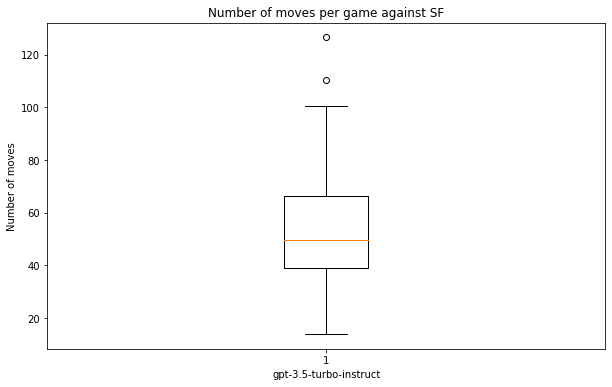

In [23]:
import matplotlib.pyplot as plt

def analyze_games(df_l, model_name):
    # Query for games played by the given model
    model_games = df_l.query(f"(white == '{model_name}' or black == '{model_name}')")
    model_games['nmoves'] = model_games['nmoves'] / 2
    
    # Sum of moves played by the model
    white_nmoves = df_l.query(f"white == '{model_name}'")['nmoves'].sum() / 2
    black_nmoves = df_l.query(f"black == '{model_name}'")['nmoves'].sum() / 2
    t_moves = model_games['nmoves'].sum()

    # Count of illegal moves
    illegal_moves = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True"))
    illegal_moves_10 = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True and illegal_move != '1-0'"))

    # Printing results
    print("illegal moves", round(illegal_moves/t_moves, 5)*100, "%")
    print("illegal_moves without 1-0:", round(illegal_moves_10/t_moves, 5)*100, "%")
    print("Total number of moves played by", model_name, ":", t_moves)
    print("White played", white_nmoves, "moves")
    print("Black played", black_nmoves, "moves")
    print("Number of moves against SF")
    print("The longest game was", model_games['nmoves'].max(), "moves")
    print("The shortest game was", model_games['nmoves'].min(), "moves")
    print("The average game length was", model_games['nmoves'].mean(), "moves")
    print("The median game length was", model_games['nmoves'].median(), "moves")

    # Plotting box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(model_games['nmoves'])
    plt.title(f"Number of moves per game against SF")
    plt.ylabel("Number of moves")
    plt.xlabel(f"{model_name}")
    plt.savefig(f"{model_name}_games_nmoves.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
analyze_games(df_non_random, 'gpt-3.5-turbo-instruct')
# analyze_games(df_non_random, 'gpt-4')



81 games played against SF
72 legal games played against SF


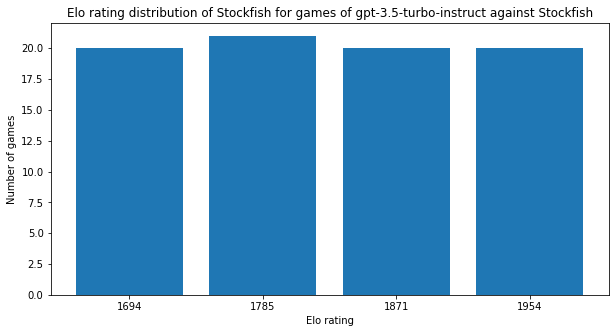

In [24]:
df_gpt35 = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")
print(len(df_gpt35), "games played against SF")
print(len(df_gpt35.query("has_illegal == False")), "legal games played against SF")

# Extracting elo values for games where Stockfish is playing against gpt-3.5-turbo-instruct
stockfish_black_elo_vs_gpt3_5_instruct = df_gpt35['black_elo']
# remove values with '?' value
stockfish_black_elo_vs_gpt3_5_instruct = stockfish_black_elo_vs_gpt3_5_instruct[stockfish_black_elo_vs_gpt3_5_instruct != '?']

stockfish_white_elo_vs_gpt3_5_instruct = df_gpt35['white_elo']
# remove values with '?' value
stockfish_white_elo_vs_gpt3_5_instruct = stockfish_white_elo_vs_gpt3_5_instruct[stockfish_white_elo_vs_gpt3_5_instruct != '?']


# Combining Elo ratings of Stockfish as both white and black player
combined_stockfish_elo = pd.concat([stockfish_white_elo_vs_gpt3_5_instruct, stockfish_black_elo_vs_gpt3_5_instruct])

import matplotlib.pyplot as plt

# Assuming you have already computed value counts
value_counts = combined_stockfish_elo.value_counts().sort_index()

# Plotting the histogram for combined Elo ratings
plt.figure(figsize=(10,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Elo rating')
plt.ylabel('Number of games')
plt.title('Elo rating distribution of Stockfish for games of gpt-3.5-turbo-instruct against Stockfish')
plt.savefig("stockfish_elo_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

def plot_histogram(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Plot histogram of nmoves
    sns.histplot(df['nmoves'], bins=30, kde=True, color="skyblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

def plot_boxplot(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create a boxplot of nmoves
    sns.boxplot(x=df['nmoves'], color="lightblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.title('Boxplot of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

In [26]:
df = df.query("random_engine == False")

In [27]:
df['temperature'].unique()

array([0.])

In [28]:
df.query('nstarting_move <= 2 and temperature == 0.0') # right now nmoves with 1 corresponds to traditional stuff... with 2 corresponds to basic, well-known, random openings and is fair... n > 2 corresponds to k random moves (and is a bit unfair for either side)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,141,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameac41f898-b3ca-4b96-90fb-19246e...,,False
1,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,58,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamecc87b77a-986f-4846-9830-095662...,,False
2,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,53,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gameb0a3fbe2-63a6-4fd4-8a69-605854...,,False
3,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,75,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc31f43d-e0e8-4301-b73f-aed98e...,,False
4,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,91,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,True,0-1,games_yosha/gameac4eefd4-b0a5-4289-84e9-7b2f93...,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,115,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamedc232246-8d2e-42b4-bef2-0cc18a...,,False
77,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,88,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea8b0b6a6-ad94-45bd-8170-522304...,,False
78,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,134,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/game8fdf34d5-b73e-4812-8789-d11428...,,False
79,Stockfish,gpt-3.5-turbo-instruct,1954,?,1/2-1/2,161,1,"[White ""Carlsen, Magnus""] \n[Black ""Kasparov,...",0.0,False,False,,games_yosha/gamea541823d-a8bb-45fa-af00-adfafc...,,False


In [29]:
df.query('nstarting_move <= 2 and temperature == 0.8')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


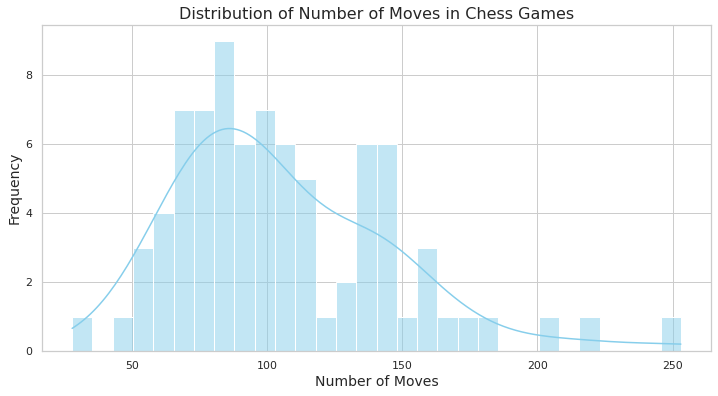

In [30]:


plot_histogram(df)
# plot_histogram(df.query('nstarting_move > 2'))


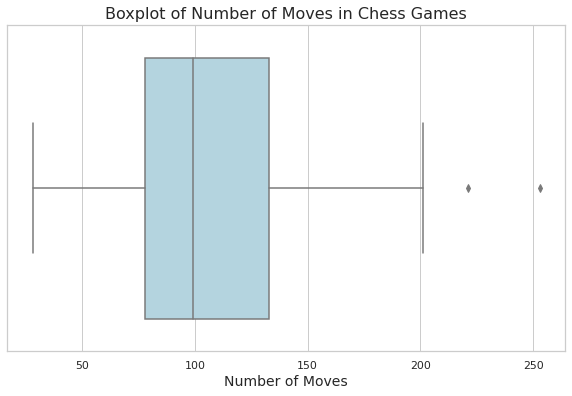

In [31]:


plot_boxplot(df)


In [32]:
def compute_average(df, model_name='gpt-3.5-turbo-instruct'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Convert Elo columns to numeric, setting errors='coerce' to handle non-numeric values
    df_copy['white_elo'] = pd.to_numeric(df_copy['white_elo'], errors='coerce')
    df_copy['black_elo'] = pd.to_numeric(df_copy['black_elo'], errors='coerce')

    # Filter out rows where gpt-3.5-turbo-instruct is the player and get the opponent's Elo
    opponent_elo_white = df_copy[df_copy['white'] == model_name]['black_elo']
    opponent_elo_black = df_copy[df_copy['black'] == model_name]['white_elo']

    # Concatenate the Elo ratings of opponents when gpt-3.5-turbo-instruct played as white and black
    all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])

    # Calculate the average Elo rating of the opponents, excluding missing or NaN values
    average_opponent_elo = all_opponent_elo.mean()

    return average_opponent_elo


In [33]:
from scipy.optimize import fsolve
import numpy as np


def computation_Elo(df,  initial_guess = 1700, model_name='gpt-3.5-turbo-instruct', K=400):
    # Given values
    S_A = compute_score(df, model_name)  # The score of Player A
    R_B = compute_average(df, model_name)  # The rating of Player 

    # Define the equation to solve for R_A
    def equation(R_A, *data):
        S_A, R_B = data
        return S_A - 1 / (1 + 10**((R_B - R_A) / K)) 

    # Solve the equation for R_A
    R_A_solution = fsolve(equation, initial_guess, args=(S_A, R_B))

    # Extract the calculated R_A value
    R_A_calculated = float(R_A_solution[0])
    return R_A_calculated

computation_Elo(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")), computation_Elo(df.query('nstarting_move <= 2 and temperature == 0.0')), computation_Elo(df.query('nstarting_move <= 2 and temperature == 0.8')), computation_Elo(df.query('nstarting_move > 2 and temperature == 0.0'))


/home/mathieuacher/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/mathieuacher/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(1762.0670615316344, 1762.0670615316344, 1700.0, 1700.0)

In [34]:

# rs = []
# for i in range(0, 1000):
#     rs.append(compute_elo(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False").sample(), candidate_name="gpt-3.5-turbo-instruct", starting_elo=1500, K=400))


def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -444, -470, -501, -538, -589, -677, -800]
        }

        # Convert to DataFrame
        df_fide = pd.DataFrame(data)

        rscore = round(score, 2)

        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp

def fide_elo_computation(dfe, model_name, score=None):
    average_opponents_ratings = compute_average(dfe, model_name)
    if score is None:
        score = compute_score(dfe, model_name)
    dp = lookup_fide_table(score)


    return average_opponents_ratings + dp

                    
def compute_elo(df_l, model_gpt_name):
    df_elo = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False")
    fide_elo_value = round(fide_elo_computation(df_elo, model_gpt_name), 0)
    print(f"{fide_elo_value} Elo for {model_gpt_name} against SF and only with legal games/moves")
    
    df_elo_withillegal = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")
    s, t = compute_score(df_elo_withillegal, model_gpt_name, percentage=False)
    sc = s / len(df_elo_withillegal)
    fide_elo_with_illegal_value = round(fide_elo_computation(df_elo_withillegal, model_gpt_name, sc), 0)
    print(f"{fide_elo_with_illegal_value} Elo for {model_gpt_name} against SF and with all games")

# Usage:
compute_elo(df_non_random, 'gpt-3.5-turbo-instruct')


print("With temperature=0")
df_non_random['temperature'] = df_non_random['temperature'].astype(float)
compute_elo(df_non_random.query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
# print("With temperature=0.8")
# compute_elo(df_non_random.query("temperature != 0"), 'gpt-3.5-turbo-instruct')




1760.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1723.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
With temperature=0
1760.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1723.0 Elo for gpt-3.5-turbo-instruct against SF and with all games


In [35]:
print("Elo with altered prompt")
# compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
# compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')").query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
# print("we don't have interactions temperature/altered prompt")
# compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')").query("temperature == 0.8"), 'gpt-3.5-turbo-instruct')

print("Elo with non altered prompt")
compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
print("Elo with non altered prompt, t=0")
compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')").query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
# print("Elo with non altered prompt, t=0.8")
# compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')").query("temperature == 0.8"), 'gpt-3.5-turbo-instruct')

Elo with altered prompt
Elo with non altered prompt
1760.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1723.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
Elo with non altered prompt, t=0
1760.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1723.0 Elo for gpt-3.5-turbo-instruct against SF and with all games


In [36]:
# df_elo_onlywhite = df_non_random.query("(white == 'gpt-3.5-turbo-instruct') and `has_illegal` == False")
# print(round(fide_elo_computation(df_elo_onlywhite, 'gpt-3.5-turbo-instruct'), 0), "Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with white pieces")

# df_elo_onlywhite_withillegal = df_non_random.query("(white == 'gpt-3.5-turbo-instruct')")
# mname = 'gpt-3.5-turbo-instruct'
# s, t = compute_score(df_elo_onlywhite_withillegal, mname, percentage=False)
# sc = s / len(df_elo_onlywhite_withillegal)
# print(round(fide_elo_computation(df_elo_onlywhite_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with white pieces")

# only black
df_elo_onlyblack_withillegal = df_non_random.query("(black == 'gpt-3.5-turbo-instruct')")
mname = 'gpt-3.5-turbo-instruct'
s, t = compute_score(df_elo_onlyblack_withillegal, mname, percentage=False)
sc = s / len(df_elo_onlyblack_withillegal)
print(round(fide_elo_computation(df_elo_onlyblack_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with black pieces")

# only black
df_elo_onlyblack = df_non_random.query("(black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False")
print(round(fide_elo_computation(df_elo_onlyblack, 'gpt-3.5-turbo-instruct'), 0), "Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with black pieces")



1723.0 Elo for gpt-3.5-turbo-instruct against SF and with all games and only with black pieces
1760.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with black pieces


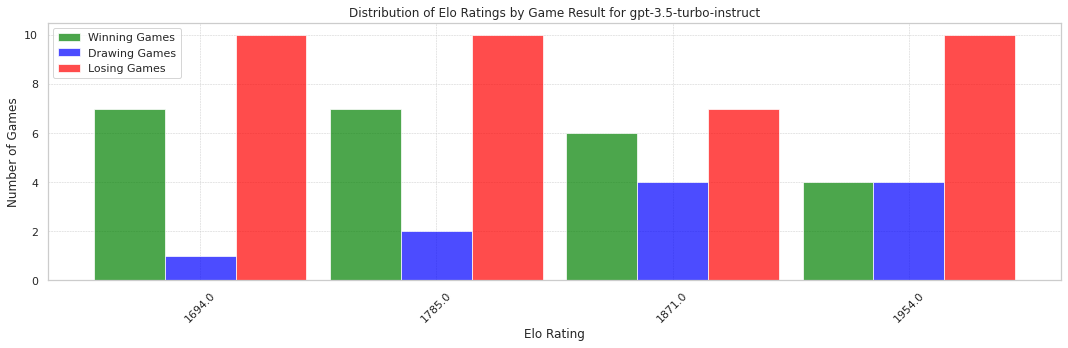

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def extract_elo_ratings(df_l, model_gpt_name):
    wrs = [] # winning games 
    lrs = [] # losing games
    drs = [] # drawing games
    
    # Filter and iterate over the dataframe
    for _, row in df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False").iterrows():
        if row['white'] == model_gpt_name and row['result'] == '1-0':
            wrs.append(row['black_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '0-1':
            wrs.append(row['white_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '1-0':
            lrs.append(row['white_elo'])
        elif row['white'] == model_gpt_name and row['result'] == '0-1':
            lrs.append(row['black_elo'])
        elif row['result'] == '1/2-1/2':
            if row['white'] == model_gpt_name:
                drs.append(row['black_elo'])
            else:
                drs.append(row['white_elo'])
        else:
            print("warning")
            print(row)
            continue

    wrs = [float(val) for val in wrs]
    lrs = [float(val) for val in lrs]
    drs = [float(val) for val in drs]
    
    return wrs, lrs, drs

def plot_elo_distribution(wrs, lrs, drs, model_gpt_name):
    # Compute unique Elos and their counts
    unique_elos = sorted(np.unique(wrs))
    win_counts = [wrs.count(elo) for elo in unique_elos]
    draw_counts = [drs.count(elo) for elo in unique_elos]
    lose_counts = [lrs.count(elo) for elo in unique_elos]

    # Plotting
    bar_width = 0.3
    index = np.arange(len(unique_elos))
    plt.figure(figsize=(15, 5))
    plt.bar(index, win_counts, bar_width, alpha=0.7, color='green', label='Winning Games')
    plt.bar(index + bar_width, draw_counts, bar_width, alpha=0.7, color='blue', label='Drawing Games')
    plt.bar(index + 2 * bar_width, lose_counts, bar_width, alpha=0.7, color='red', label='Losing Games')

    plt.xlabel('Elo Rating')
    plt.ylabel('Number of Games')
    plt.title(f'Distribution of Elo Ratings by Game Result for {model_gpt_name}')

    plt.xticks(index + bar_width, unique_elos, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"elo_distribution-scores-{model_gpt_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_and_plot_elo_distribution(df_l, model_gpt_name):
    wrs, lrs, drs = extract_elo_ratings(df_l, model_gpt_name)
    plot_elo_distribution(wrs, lrs, drs, model_gpt_name)



# Return the functions for further use
analyze_and_plot_elo_distribution(df_non_random, "gpt-3.5-turbo-instruct")

# df_non_random


# analyze_and_plot_elo_distribution(df_non_random.query("not pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
# analyze_and_plot_elo_distribution(df_non_random.query("pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')






In [38]:
final_elo = fide_elo_computation(df.query('nstarting_move <= 2 and temperature == 0.0'), 'gpt-3.5-turbo-instruct') # starting_elo=1700, K=40)
print(f"Final Elo of gpt-3.5-turbo-instruct: {final_elo}")



Final Elo of gpt-3.5-turbo-instruct: 1760.4938271604938


In [39]:
for k, v in df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False").iterrows():
    if v['white'] == "gpt-3.5-turbo-instruct" and v['black_elo'] != '?':
            opponent_elo = float(v['black_elo'])
    elif v['black'] == "gpt-3.5-turbo-instruct" and v['white_elo'] != '?':
        opponent_elo = float(v['white_elo'])
    else:
        print("warning: no elo found for opponent", k, v['folder_name'])
        continue
    result = v['result']
    if result == '*':
        print("warning: no result found for opponent", k, v['folder_name'])
        continue

In [40]:
len(df.query('nstarting_move > 2'))

0

In [41]:
df.query('nstarting_move > 2')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [42]:
df['has_illegal'].unique()

array([False, True], dtype=object)

In [43]:
df['illegal_move'].value_counts()

       72
0-1     9
Name: illegal_move, dtype: int64

In [44]:
df['base_pgn_prompt'].value_counts()

False    81
Name: base_pgn_prompt, dtype: int64

In [45]:
computation_Elo(df.query('base_pgn_prompt == False'))

1762.0670615316344

In [46]:
df.query("(white == 'gpt-4' or black == 'gpt-4')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [47]:
df.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [48]:
computation_Elo(df.query("(white == 'gpt-4' or black == 'gpt-4') and has_illegal == False"), model_name='gpt-4')

/home/mathieuacher/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1700.0